In [1]:
#! /usr/bin/env python
%matplotlib inline
import healpy as hp
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy_healpix import HEALPix
from astropy.coordinates import Galactic
from astropy.coordinates import SkyCoord
import astropy.units as u
from matplotlib import pylab
from astropy.table import Table
from scipy.stats import gaussian_kde
from dustmaps.planck import PlanckQuery
import matplotlib as mpl
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.patheffects as pe
from astropy.io import ascii

In [2]:
from sklearn.neighbors import KernelDensity
def kde2D(x, y, bandwidth, xbins=100j, ybins=100j, **kwargs): 
    """Build 2D kernel density estimate (KDE)."""

    # create grid of sample locations (default: 100x100)
    xx, yy = np.mgrid[x.min():x.max():xbins, 
                      y.min():y.max():ybins]

    xy_sample = np.vstack([yy.ravel(), xx.ravel()]).T
    xy_train  = np.vstack([y, x]).T

    kde_skl = KernelDensity(bandwidth=bandwidth, **kwargs)
    kde_skl.fit(xy_train)

    # score_samples() returns the log-likelihood of the samples
    z = np.exp(kde_skl.score_samples(xy_sample))
    return xx, yy, np.reshape(z, xx.shape)  

In [3]:
def ips2isdss_a(gr, ip1):
    x = gr
    a0 = -0.005
    a1 = 0.011
    a2 = 0.010
    y = a0 + a1*x + a2*(x**2)
    isdss = y + ip1
    return isdss

In [4]:
def ips2isdss_b(gr, ip1):
    x = gr
    b0 = -0.004
    b1 = 0.020
    y = b0 + b1*x
    isdss = y + ip1
    return isdss

In [5]:
SMALL_SIZE = 16
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE, family='serif')    # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.serif'] = ['Times New Roman']

In [6]:
ktb = Table.read('./kcorrect_richards_2006_tb4.txt', format='ascii.cds')

In [7]:
ktb

z,KCorr
float64,float64
0.0,0.596
0.01,0.587
0.02,0.569
0.03,0.531
0.04,0.462
0.05,0.372
0.06,0.268
0.07,0.203
0.08,0.17


In [8]:
from scipy import interpolate
K_correct = interpolate.interp1d(ktb['z'], ktb['KCorr'])

In [9]:
df = pd.read_csv('/home/yuming/astro/format_catalog/GPQC_catalog_v1c.csv')

/home/yuming/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3444: DtypeWarning: Columns (59,60) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [10]:
df['i_sdss'] = ips2isdss_a(df['gmag']-df['rmag'], df['imag'])
df['i_ori'] = df['i_sdss'] - df['ebv']*0.630*3.1
df['kcorr'] = K_correct(df['photoz'])

In [11]:
df['i_ori']

0         20.018256
1         19.243599
2         17.118620
3         19.666791
4         19.915188
            ...    
160941    20.027319
160942    19.572541
160943    19.947298
160944    20.184453
160945    19.858976
Name: i_ori, Length: 160946, dtype: float64

In [12]:
from astropy.cosmology import LambdaCDM
cosmo = LambdaCDM(H0=70, Om0=0.3, Ode0=0.7)

In [13]:
df['iabs'] = df['i_ori']-cosmo.distmod(df['photoz']).value-df['kcorr']

In [14]:
ka = kde2D(df['photoz'], df['iabs'], 0.05)

In [15]:
df1 = pd.read_csv("/home/yuming/astro/spec_fit/fit_gpqs/combined/fitted_gpq_basev21_filledPS1.csv")

In [16]:
coords = SkyCoord(ra=df1.ra.values*u.deg, 
                  dec=df1.dec.values*u.deg,
                  frame='icrs')

In [17]:
planck = PlanckQuery()

In [18]:
ebv1 = planck(coords)

In [19]:
df1['i_sdss'] = ips2isdss_a(df1['gmag']-df1['rmag'], df1['imag'])
df1['i_ori'] = df1['i_sdss'] - ebv1*0.630*3.1
df1['kcorr'] = K_correct(df1['redshift'])

In [20]:
df1['iabs'] = df1['i_ori']-cosmo.distmod(df1['redshift']).value-df1['kcorr']

In [21]:
from scipy.stats import gaussian_kde

#KDE for top marginal
kde_X = gaussian_kde(df['photoz'])
#KDE for right marginal
kde_Y = gaussian_kde(df['iabs'])
#KDE for contour plot
# kde_XY = gaussian_kde(data)

xmin, ymin = df['photoz'].min(), -32
xmax, ymax = df['photoz'].max(), -19

# Create two 1D grid with 100 points in each dimension
x = np.linspace(xmin, xmax, 100)
y = np.linspace(ymin, ymax, 100)

# Create a regular 2D grid with 100 points in each dimension
xi, yi = np.mgrid[xmin:xmax:100j, ymin:ymax:100j]
coords = np.vstack([item.ravel() for item in [xi, yi]])

# # Evaluate the KDEs on a 1D grid
dx = kde_X(x) # X-marginal density
dy = kde_Y(y) # Y-marginal density

# dx = np.sqrt(kde_X(x)) # X-marginal density
# dy = np.sqrt(kde_Y(y)) # Y-marginal density

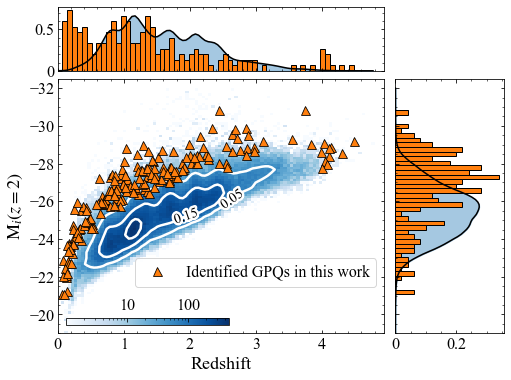

In [22]:
from matplotlib import gridspec
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import LogNorm

# gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1], height_ratios = [1, 3])
gs = gridspec.GridSpec(2, 2,
                       width_ratios=[3, 1],
                       height_ratios=[1,4],
                       wspace=0.05,
                       hspace=0.05)

fig = plt.figure(figsize=(8, 6))
ax = plt.subplot(gs[1, 0])

histax = ax.hist2d(df['photoz'],df['iabs'],
                bins=100,
                range=[[0,4.95],[-32,-19]],
                norm=LogNorm(),
                cmap='Blues',
                rasterized=True,
                label='GPQ candidate catalog')

levels = [0.05, 0.15, 0.3]
CS = ax.contour(ka[0], ka[1], ka[2], 
        levels=levels,
        colors=('w',),
        linewidths=(2.5,))
clbls = ax.clabel(CS, fmt='%.2f', 
                  colors='k', inline=False, fontsize=14,
                  use_clabeltext=True)
plt.setp(clbls, path_effects=[pe.withStroke(linewidth=5,
                                            foreground="w")])

line1, = ax.plot(df1['redshift'], 
                 df1['iabs'], 
                 ls='',
                 marker='^', 
                 mfc='C1',
                 mec='k',
                 ms=9,
                 mew=0.8,
                 label='Identified GPQs in this work')
ax.set_xlabel('Redshift')
ax.set_ylabel('$\mathrm{M}_{i} (z=2)$')
axr = plt.subplot(gs[1,1], 
                  sharey = ax, 
#                   xlim = (0, 1.1*dy.max()), 
                  ylim=(-19, -32.5)
                 )
# axr.set_ylim(0,0.8)
axr.plot(dy, y, color = 'black')
axr.fill_betweenx(y, 0, dy, alpha=0.4, color = 'C0')
axr.hist(df1['iabs'], bins=40, alpha=1, density=True,
         histtype='bar', color='C1',
         edgecolor='k', orientation='horizontal');
axr.minorticks_on()
axr.set_xticks([0,0.2])
axr.set_xticklabels(['0','0.2'])

#Create X-marginal (top)
axt = plt.subplot(gs[0,0], 
                  sharex = ax, 
#                   xlim = (xmin, xmax), 
#                   ylim=(0, 1.1*dx.max())
                 )
axt.plot(x, dx, color = 'black')
axt.fill_between(x, 0, dx, alpha=0.4, color = 'C0')
axt.hist(df1['redshift'], bins=60, alpha=1, density=True,
         histtype='bar', color='C1',
         edgecolor='k');
axt.minorticks_on()
axt.set_yticks([0,0.5])
axt.set_yticklabels(['0','0.5'])
# axt.grid(ls='--',which='major')

plt.setp(axr.get_yticklabels(), visible=False);
plt.setp(axt.get_xticklabels(), visible=False);
# fig.tight_layout(pad = 0)
# fig.tight_layout(pad=0.1)

# # Set labels on marginals
# axr.set_xlabel('$PDF$')
# axt.set_ylabel('$PDF$')

axins1 = inset_axes(ax,
                    width="50%",  # width = 50% of parent_bbox width
                    height="3%",  # height : 5%
                    loc=3)
fig.colorbar(histax[3], 
             cax=axins1, 
             orientation="horizontal",
             ticks=[0,10,100]
            )
axins1.xaxis.set_ticks_position("top")
axins1.set_xticklabels(['0','10','100']);  # horizontal colorbar
# axins1.set_xlabel('Count')
ax.legend(loc=4, bbox_to_anchor=(1,0.15))
plt.savefig('gpq2_joint_z_absimag.pdf',
            bbox_inches='tight',
            dpi=300)
plt.savefig('gpq2_joint_z_absimag.jpg',bbox_inches='tight',dpi=300)

In [23]:
df1.to_csv("/home/yuming/astro/spec_fit/fit_gpqs/combined/fitted_gpq_basev21_filledPS1_mi.csv", index=False)

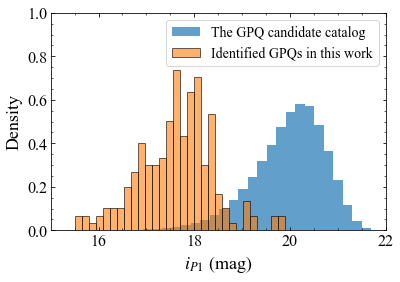

In [24]:
plt.figure()
plt.hist(df['imag'], 
         bins=40, 
         alpha=0.7, 
         density=True,
         histtype='stepfilled', 
         color='C0',
#          edgecolor='k',
         label='The GPQ candidate catalog');
plt.hist(df1['imag'], 
         bins=30, 
         alpha=0.6, 
         density=True,
         histtype='bar', 
         color='C1',
         edgecolor='k',
         label='Identified GPQs in this work');
plt.minorticks_on()
plt.ylim([0,1])
plt.xlim([15,22])
plt.legend(fontsize=14)
plt.xlabel('$i_{P1}$ (mag)');
plt.ylabel('Density');
plt.savefig('gpq2_hist_apimag.pdf',
            bbox_inches='tight')
plt.savefig('gpq2_hist_apimag.jpg',bbox_inches='tight',dpi=300)

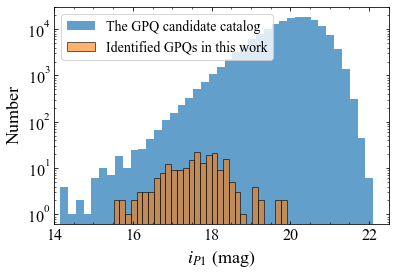

In [31]:
plt.figure()
plt.hist(df['imag'], 
         bins=40, 
         alpha=0.7, 
         log=True,
         histtype='stepfilled', 
         color='C0',
#          edgecolor='k',
         label='The GPQ candidate catalog');
plt.hist(df1['imag'], 
         bins=30, 
         alpha=0.6, 
         log=True,
         histtype='bar', 
         color='C1',
         edgecolor='k',
         label='Identified GPQs in this work');
plt.minorticks_on()
plt.xlim([14,22.5])
plt.legend(loc=2,fontsize=14)
plt.xlabel('$i_{P1}$ (mag)');
plt.ylabel('Number');
plt.savefig('gpq2_hist_apimag_log.pdf',
            bbox_inches='tight')
plt.savefig('gpq2_hist_apimag_log.jpg',bbox_inches='tight',dpi=300)

In [36]:
np.sin(np.deg2rad(20))*2/2

0.3420201433256687

In [38]:
14109.3/(20626.48*2)

0.3420190939025951